# Analysis for Figure3

In [6]:
1

1

In [2]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import scanpy.external as sce
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import rapids_singlecell as rsc
import scanpy as sc
import cupyx as cpx
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scib
import scib_metrics

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

sc.settings.verbosity = 3

print(f"CUDA used: {torch.cuda.is_available()}")

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/xla.py:18: DeprecationWarning: `ModuleAvailableCache` is a special case of `RequirementCache`. Please use `RequirementCache(module=...)` instead.
  from lightning.fabric.accelerators.tpu import _XLA_AVAILABLE, TPUAccelerator
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_na

CUDA used: True


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [4]:
# !ls /lustre/groups/ml01/workspace/kemal.inecik/tardis_data/processed

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Braun.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
    adata.obs["age"] = adata.obs["age"].astype("str").astype("category")

In [ ]:
adata_file_path_large = (
    "/lustre/groups/ml01/workspace/kemal.inecik/hdca/" "temp/preprocessing/unification_union_20240330_hvg.h5ad"
)
complete_varnames=ad.read_h5ad(adata_file_path_large, backed='r').var.copy()

adata_var_pickle = os.path.join(tardis.config.io_directories["processed"], "dataset_complete_Braun_varnames.pickle")
adata.var = complete_varnames.loc[pd.read_pickle(adata_var_pickle).index]

In [ ]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "braun_age-continuous"
)
vae = tardis.MyModel.load(dir_path, adata=adata)

In [7]:
vae.history["kl_local_train"].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', name='epoch', length=1000)

In [8]:
adata.obs["age_continuous"] = adata.obs["age"].astype(float)

In [9]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
rsc.utils.anndata_to_GPU(latent)
rsc.pp.neighbors(adata=latent, n_neighbors = 30)
rsc.tl.umap(adata=latent)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/cupy/sparse/__init__.py:17: DeprecationWarning: cupy.sparse is deprecated. Use cupyx.scipy.sparse instead.
  warnings.warn(msg, DeprecationWarning)


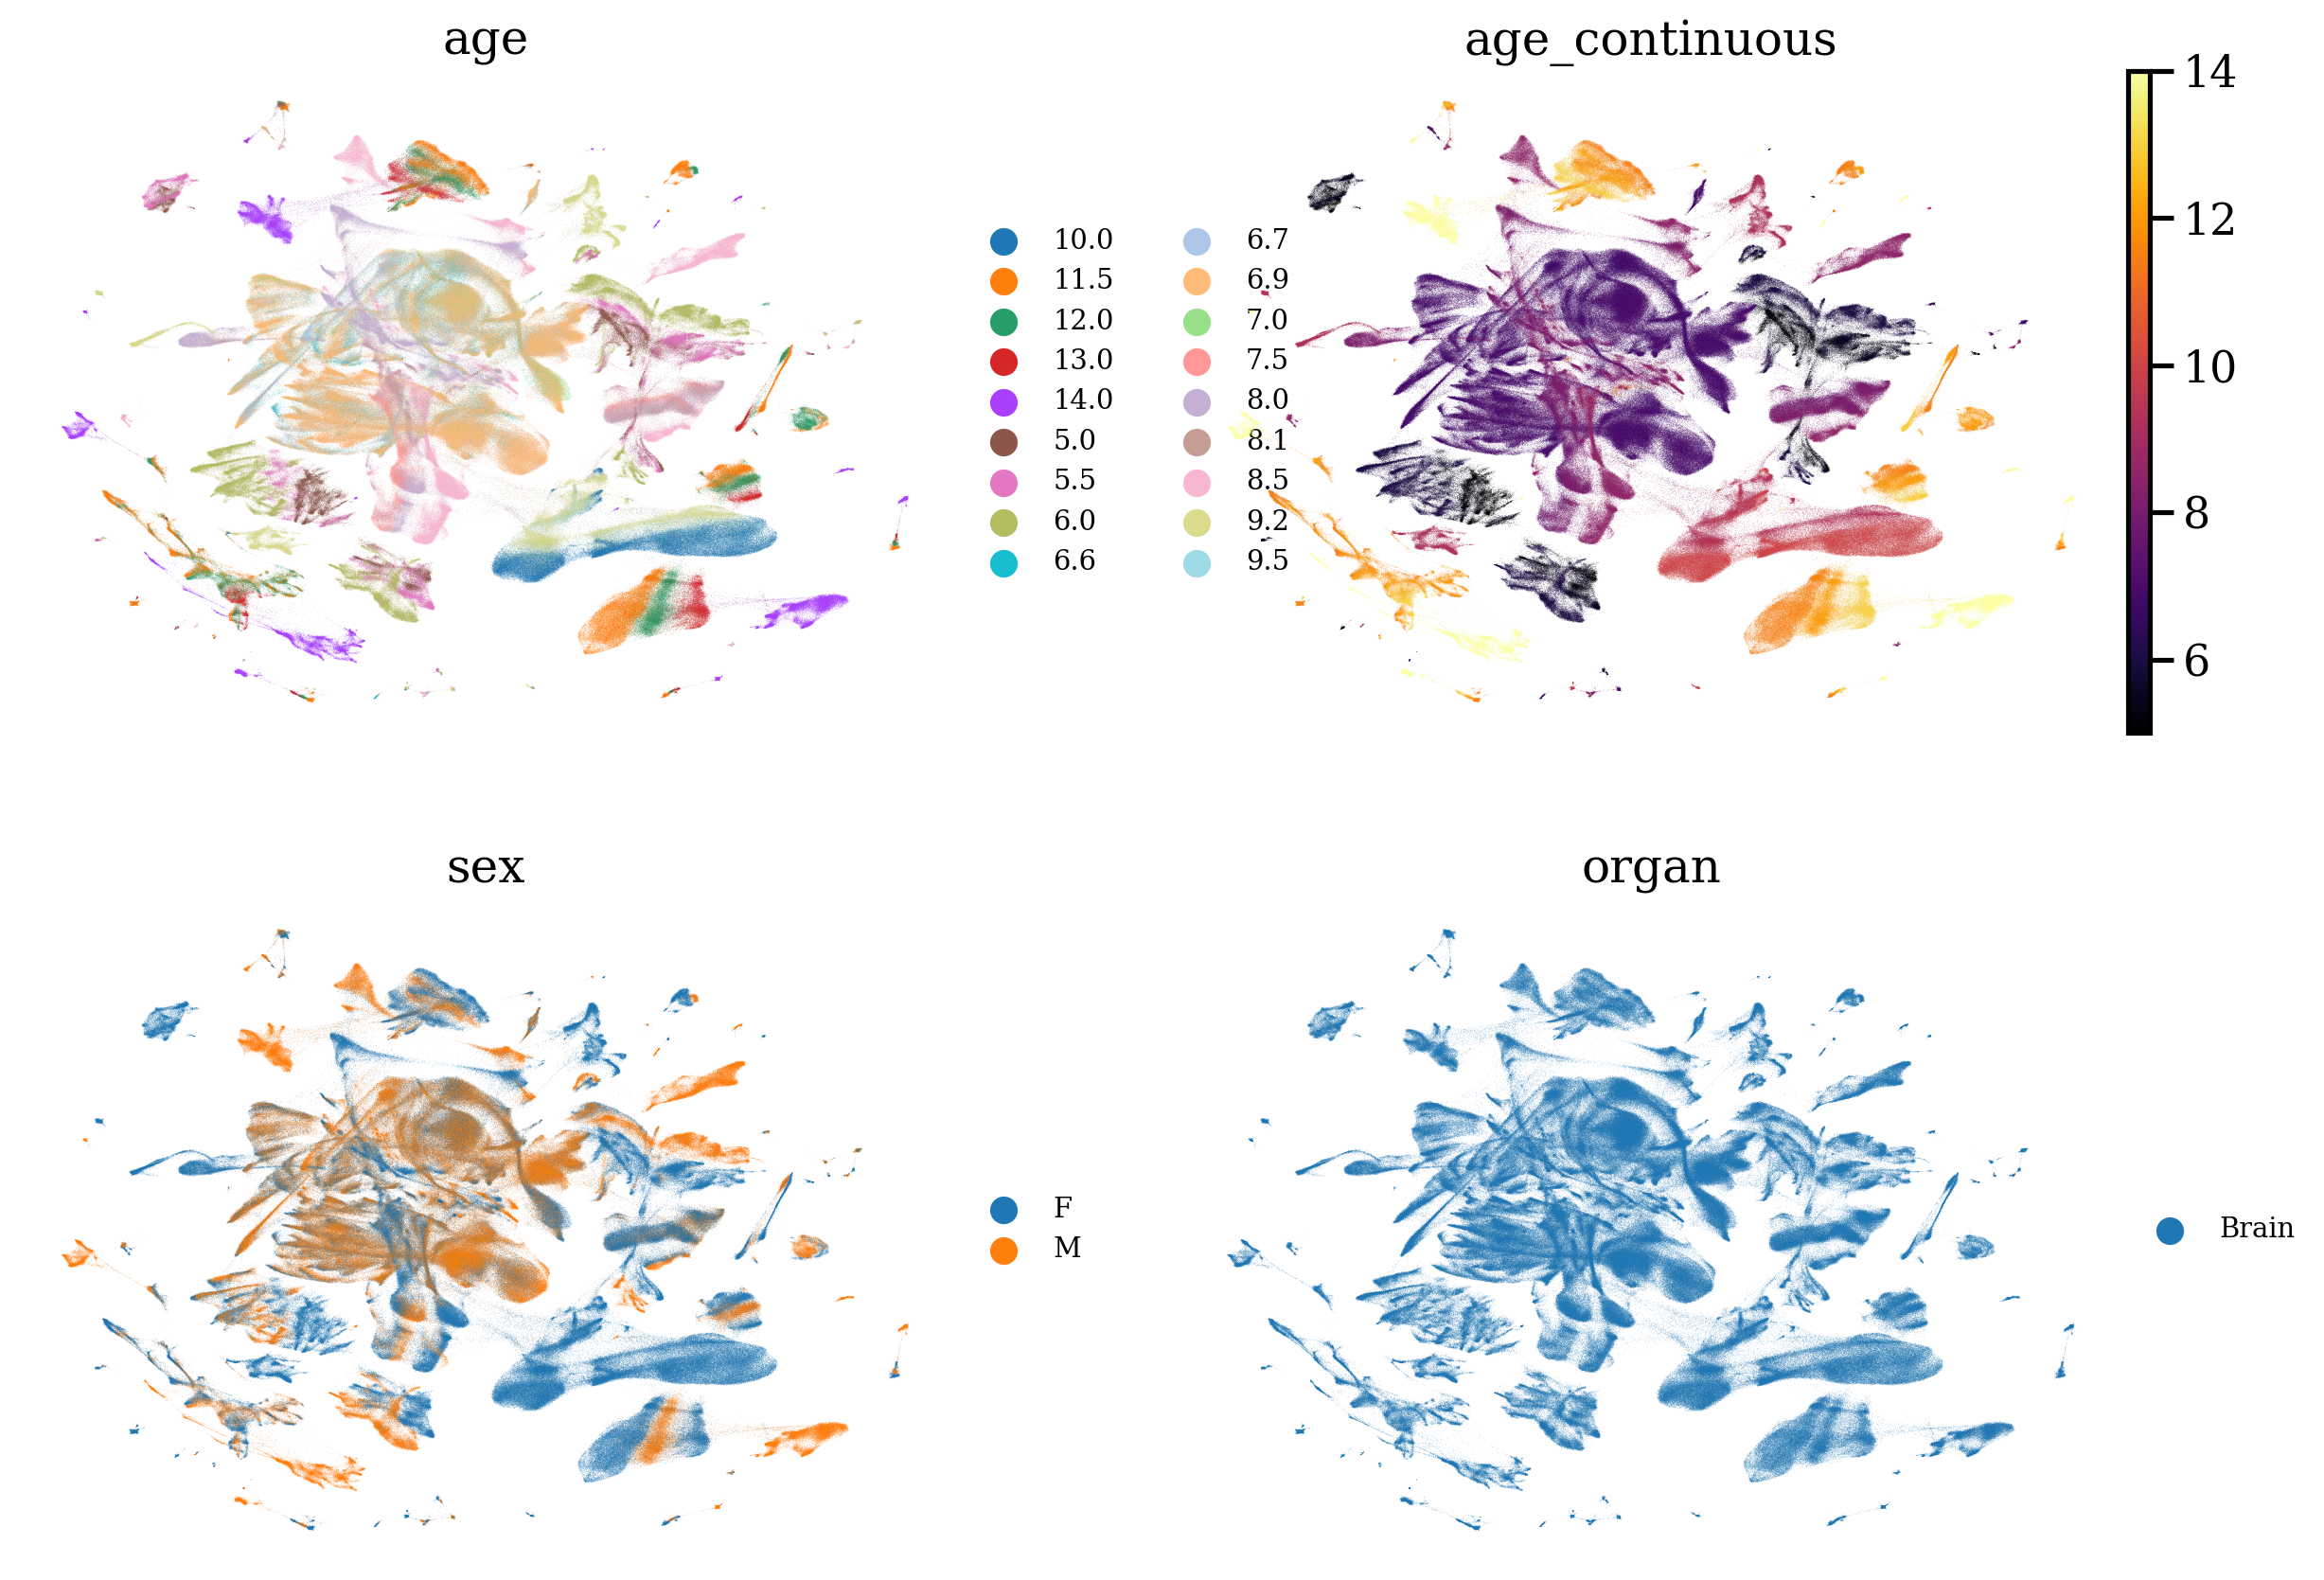

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent,
        color=["age", "age_continuous", "sex", "organ"],
        ncols=2,
        color_map="inferno",
        frameon=False,
        legend_fontsize="xx-small",
        show=False,
    )
    plt.show()
    # del latent
    # gc.collect()

In [9]:
from tardis._disentanglementmanager import DisentanglementManager

In [10]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentanglementManager.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
rsc.utils.anndata_to_GPU(latent)
rsc.pp.neighbors(adata=latent, n_neighbors = 30)
rsc.tl.umap(adata=latent)
rsc.utils.anndata_to_CPU(latent)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/cupy/sparse/__init__.py:17: DeprecationWarning: cupy.sparse is deprecated. Use cupyx.scipy.sparse instead.
  warnings.warn(msg, DeprecationWarning)


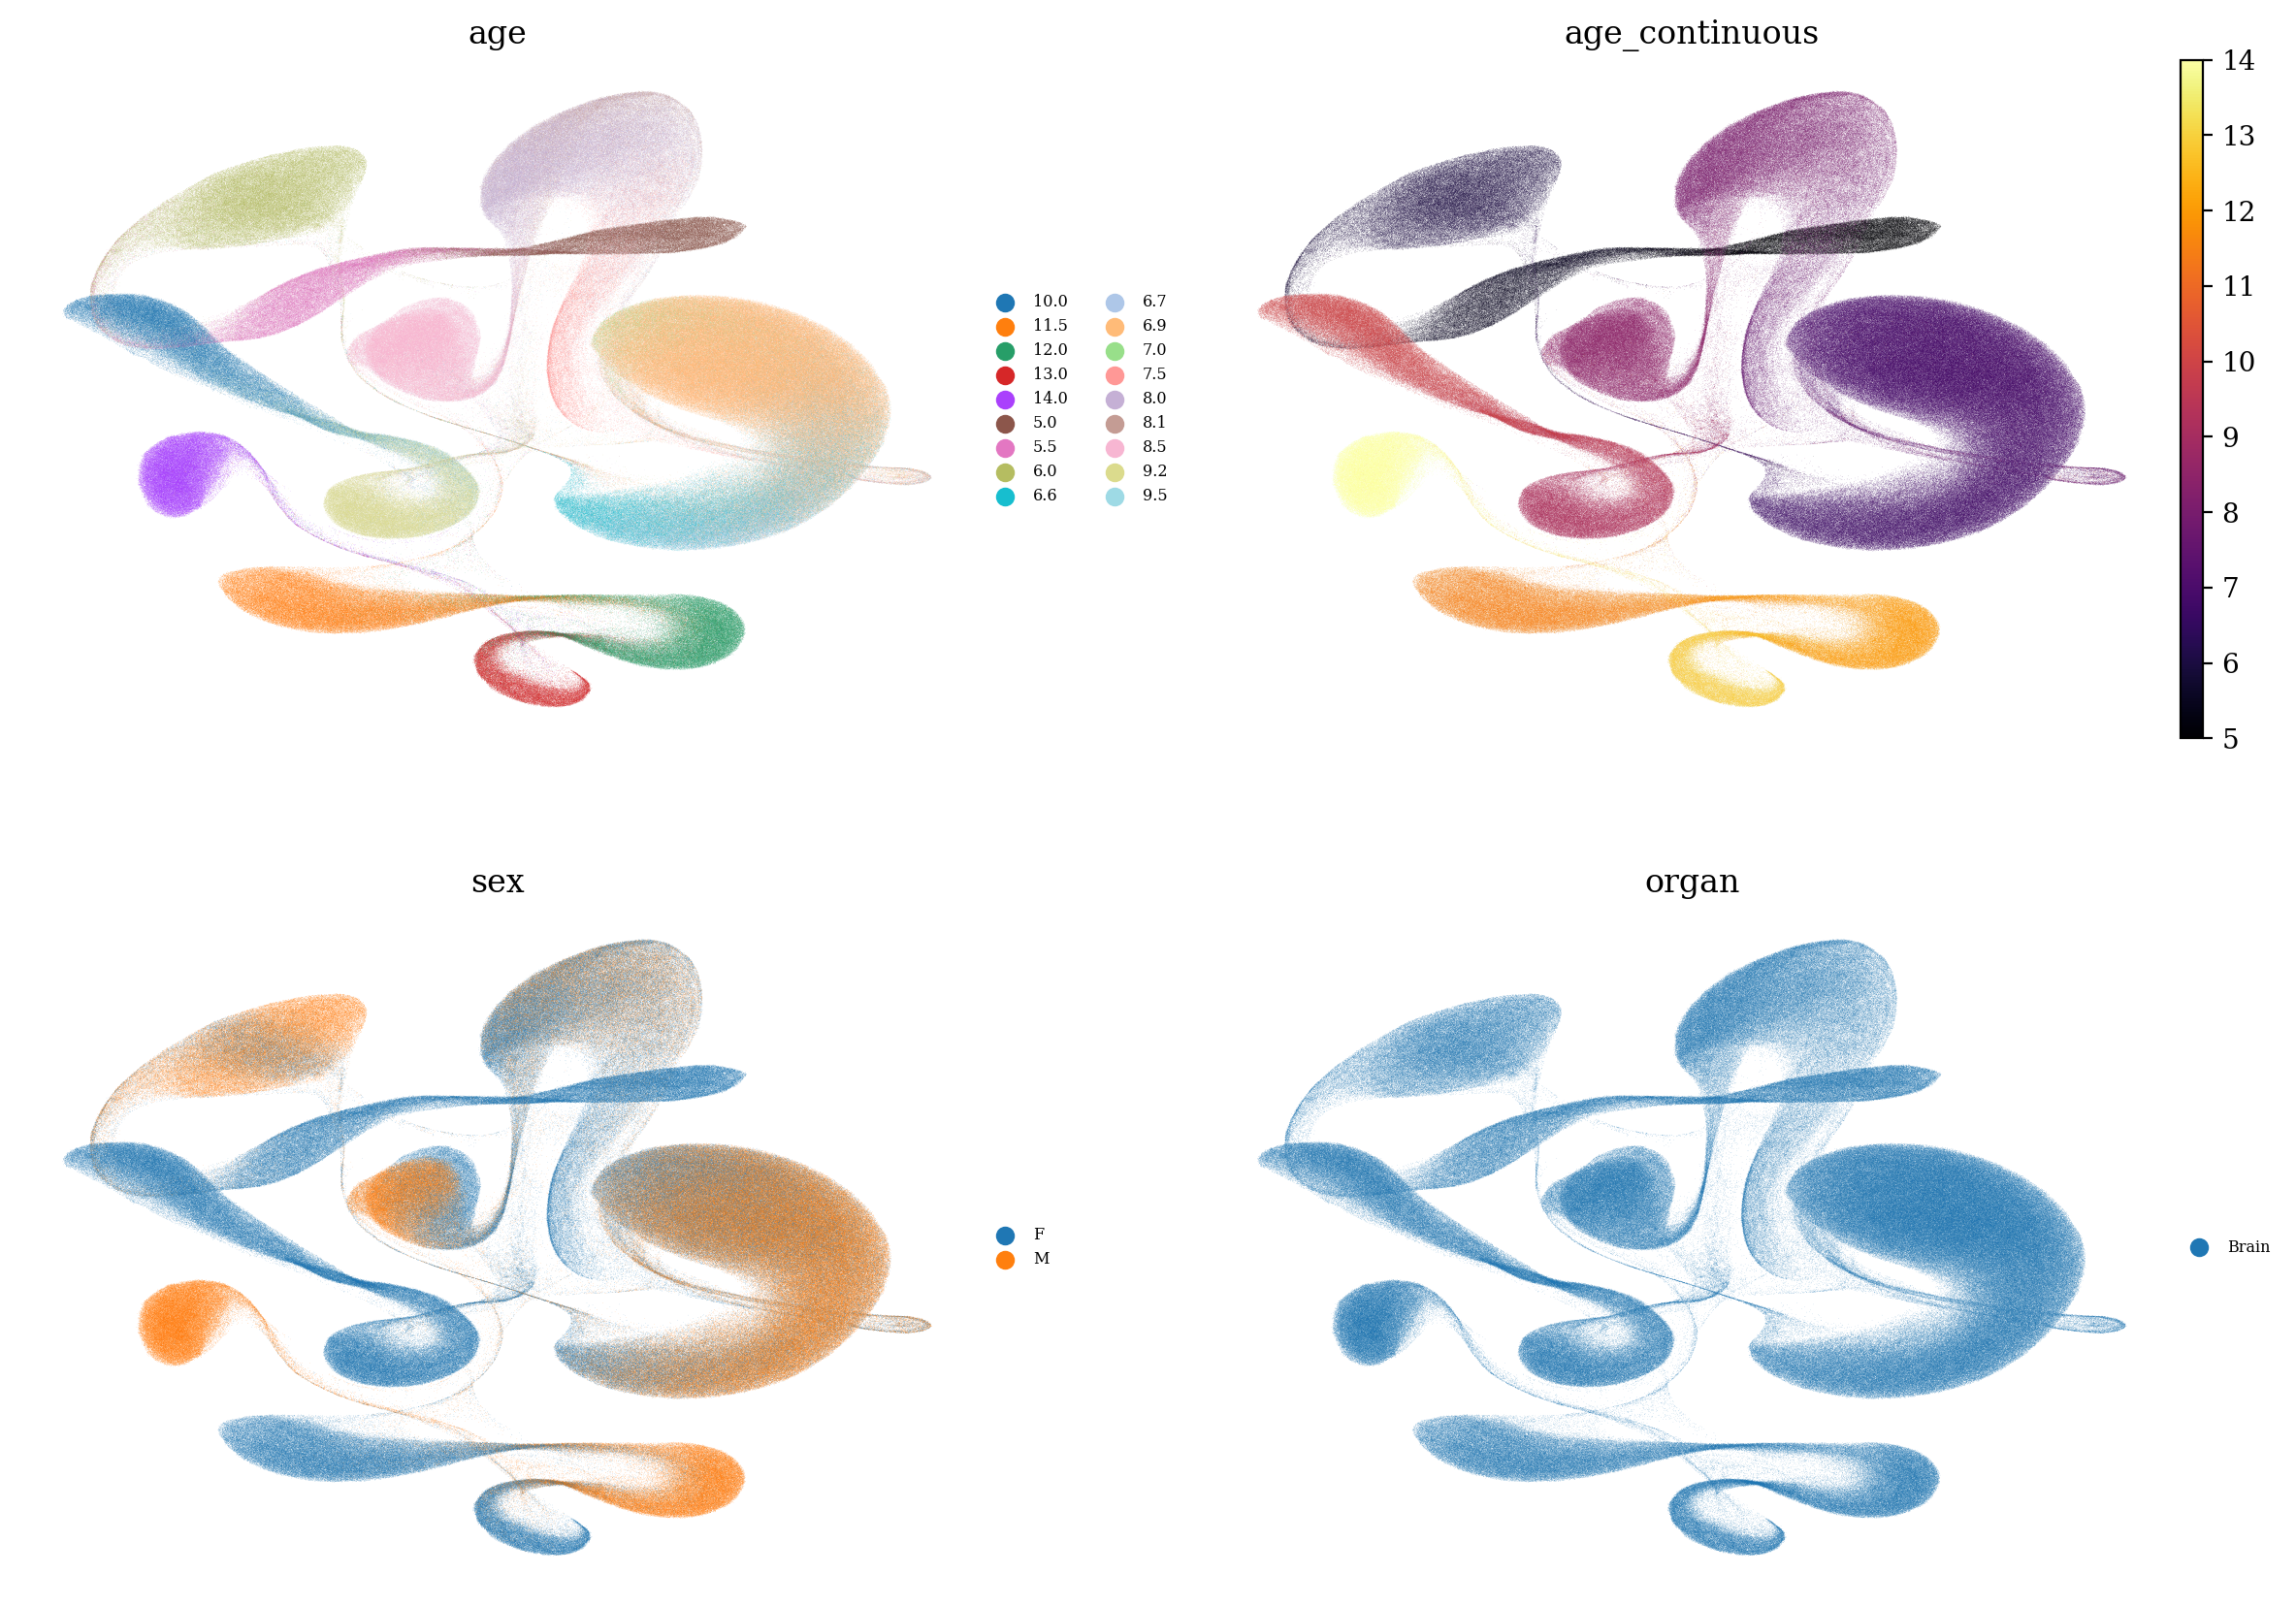

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent,
        color=["age", "age_continuous", "sex", "organ"],
        ncols=2,
        color_map="inferno",
        frameon=False,
        legend_fontsize="xx-small",
        show=False,
    )
    plt.show()
    # del latent
    # gc.collect()

In [12]:
latent

AnnData object with n_obs × n_vars = 1661498 × 8
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', '_scvi_batch', '_scvi_labels', 'age_continuous'
    uns: 'neighbors', 'umap', 'age_colors', 'sex_colors', 'organ_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [13]:
sc.tl.pca(latent, n_comps=7)

computing PCA
    with n_comps=7
    finished (0:00:01)


In [14]:
latent

AnnData object with n_obs × n_vars = 1661498 × 8
    obs: 'sample_ID', 'organ', 'age', 'cell_type', 'sex', 'sex_inferred', 'concatenated_integration_covariates', 'integration_donor', 'integration_biological_unit', 'integration_sample_status', 'integration_library_platform_coarse', 'n_genes', '_scvi_batch', '_scvi_labels', 'age_continuous'
    uns: 'neighbors', 'umap', 'age_colors', 'sex_colors', 'organ_colors', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [15]:
latent.obs["pca1"] = latent.obsm["X_pca"][:, 0].copy()

In [16]:
# latent.obs["pcalog"] = np.log(latent.obs["pca1"] + 10)

<Axes: xlabel='age_continuous', ylabel='pca1'>

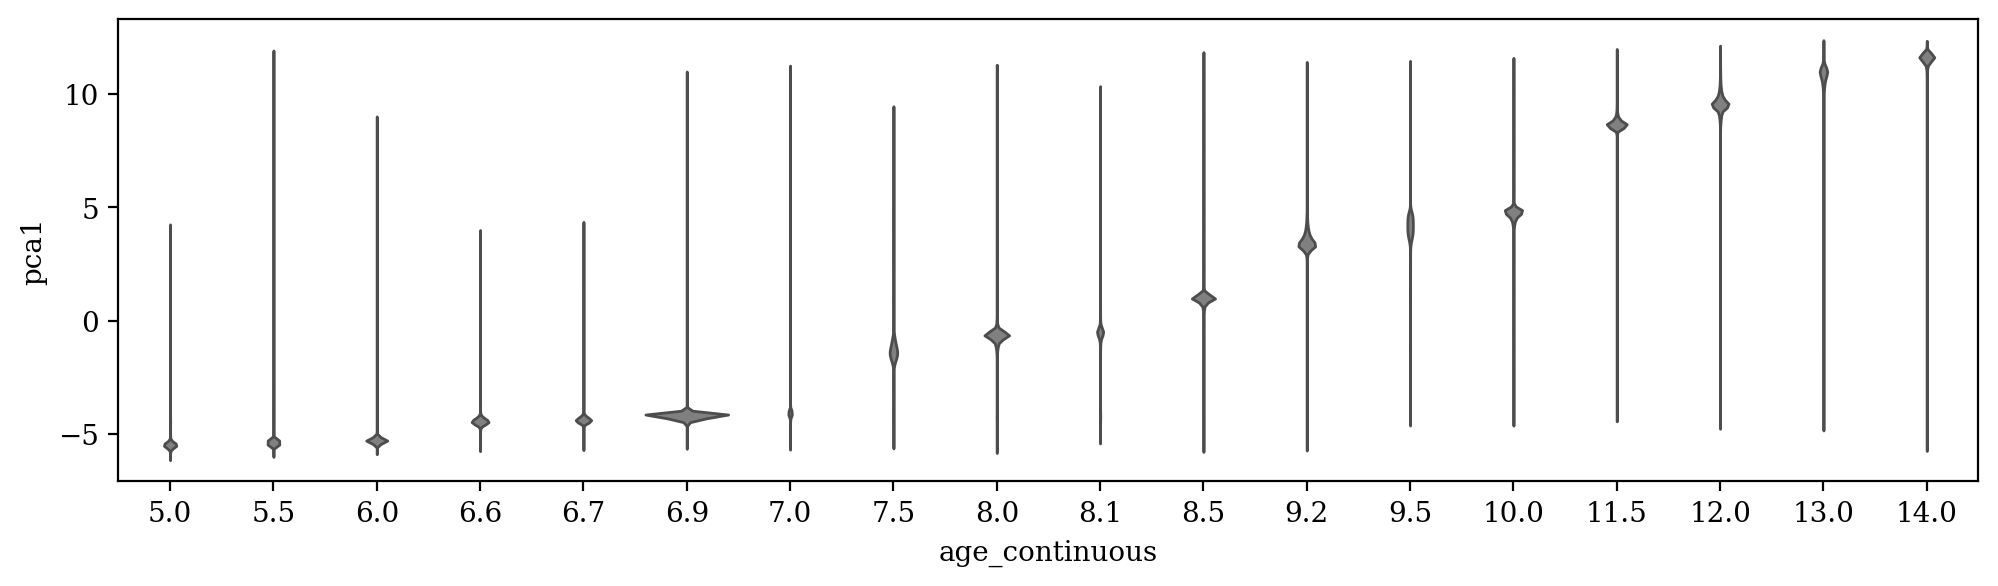

In [17]:
plt.figure(figsize=(12, 3))
sns.violinplot(data=latent.obs, x="age_continuous", y="pca1", linewidth=1, color="gray", inner=None, density_norm="count")

<Axes: xlabel='age_continuous', ylabel='pca1'>

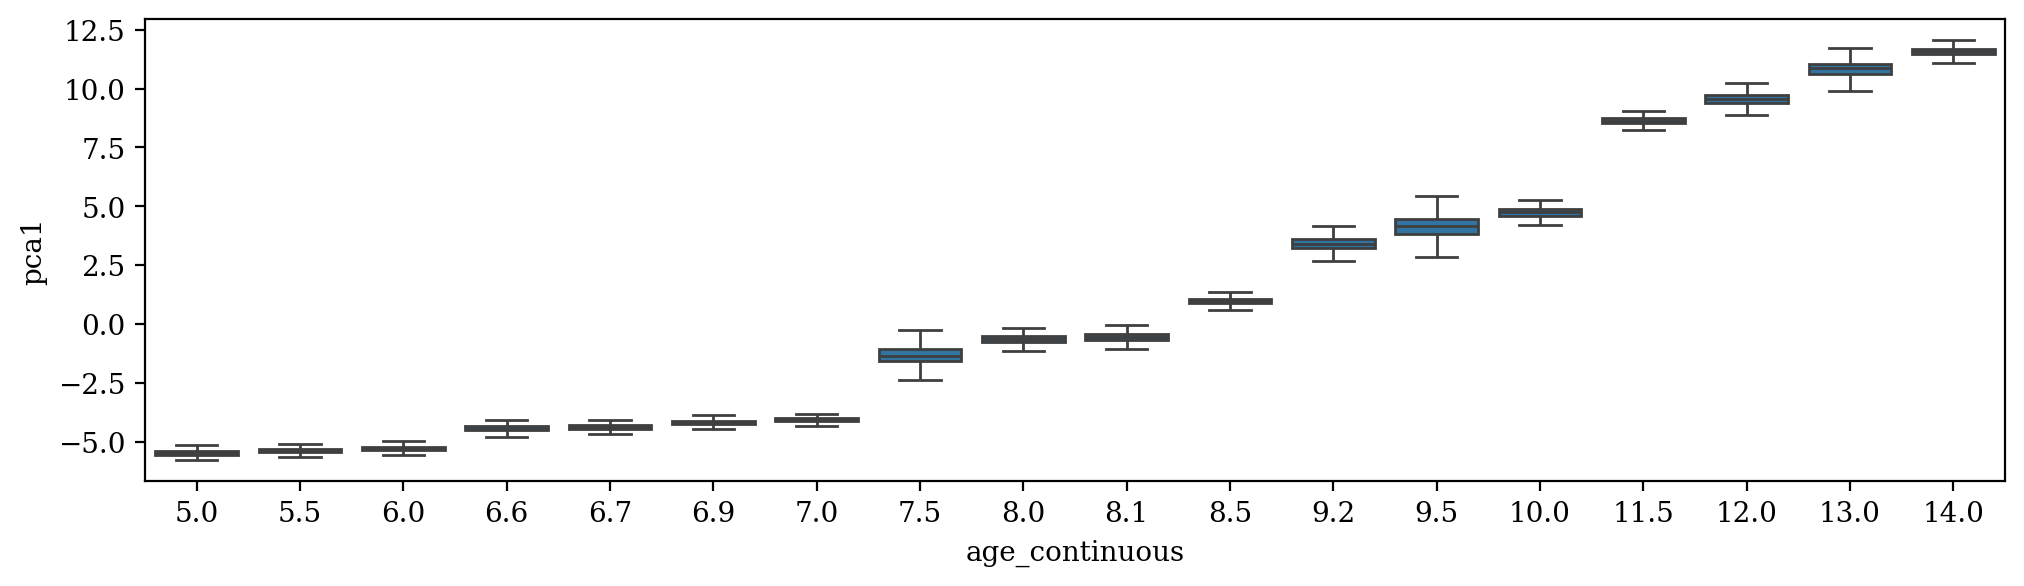

In [19]:
plt.figure(figsize=(12, 3))
sns.boxplot(data=latent.obs, x="age_continuous", y="pca1", linewidth=1, showfliers=False)

In [20]:
scipy.stats.spearmanr(latent.obs["pca1"], latent.obs["age_continuous"])

SignificanceResult(statistic=0.9765256239775746, pvalue=0.0)

In [21]:
# get stats from the braun only

In [23]:
list(latent.obs["cell_type"].unique())

['Brain erythrocytes',
 'Brain fibroblasts',
 'Cortex glioblast',
 'Hypothalamus glioblast',
 'Ventral midbrain glioblast',
 'Subcortex glioblast',
 'Forebrain glioblast',
 'Midbrain glioblast',
 'Medulla glioblast',
 'Diencephalon glioblast',
 'Striatum glioblast',
 'Telencephalon glioblast',
 'Hindbrain glioblast',
 'Dorsal midbrain glioblast',
 'Thalamus glioblast',
 'Pons glioblast',
 'Hippocampus glioblast',
 'Cerebellum glioblast',
 'Cortex immune cells',
 'Hypothalamus immune cells',
 'Thalamus immune cells',
 'Ventral midbrain immune cells',
 'Subcortex immune cells',
 'Forebrain immune cells',
 'Cerebellum immune cells',
 'Dorsal midbrain immune cells',
 'Midbrain immune cells',
 'Medulla immune cells',
 'Pons immune cells',
 'Diencephalon immune cells',
 'Striatum immune cells',
 'Hindbrain immune cells',
 'Head immune cells',
 'Hippocampus immune cells',
 'Cortex neuroblast',
 'Cerebellum neural crest cells',
 'Medulla neural crest cells',
 'Pons neural crest cells',
 'Midbr

In [24]:
adata_calc = adata.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.scale(adata)

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [57]:
_latent = latent[latent.obs["cell_type"] == "Medulla neuron"].copy()
_latent.shape

(38329, 8)

In [58]:
# sc.tl.pca(_latent, n_comps=7)
# _latent.obs["pca1"] = _latent.obsm["X_pca"][:, 0].copy()

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


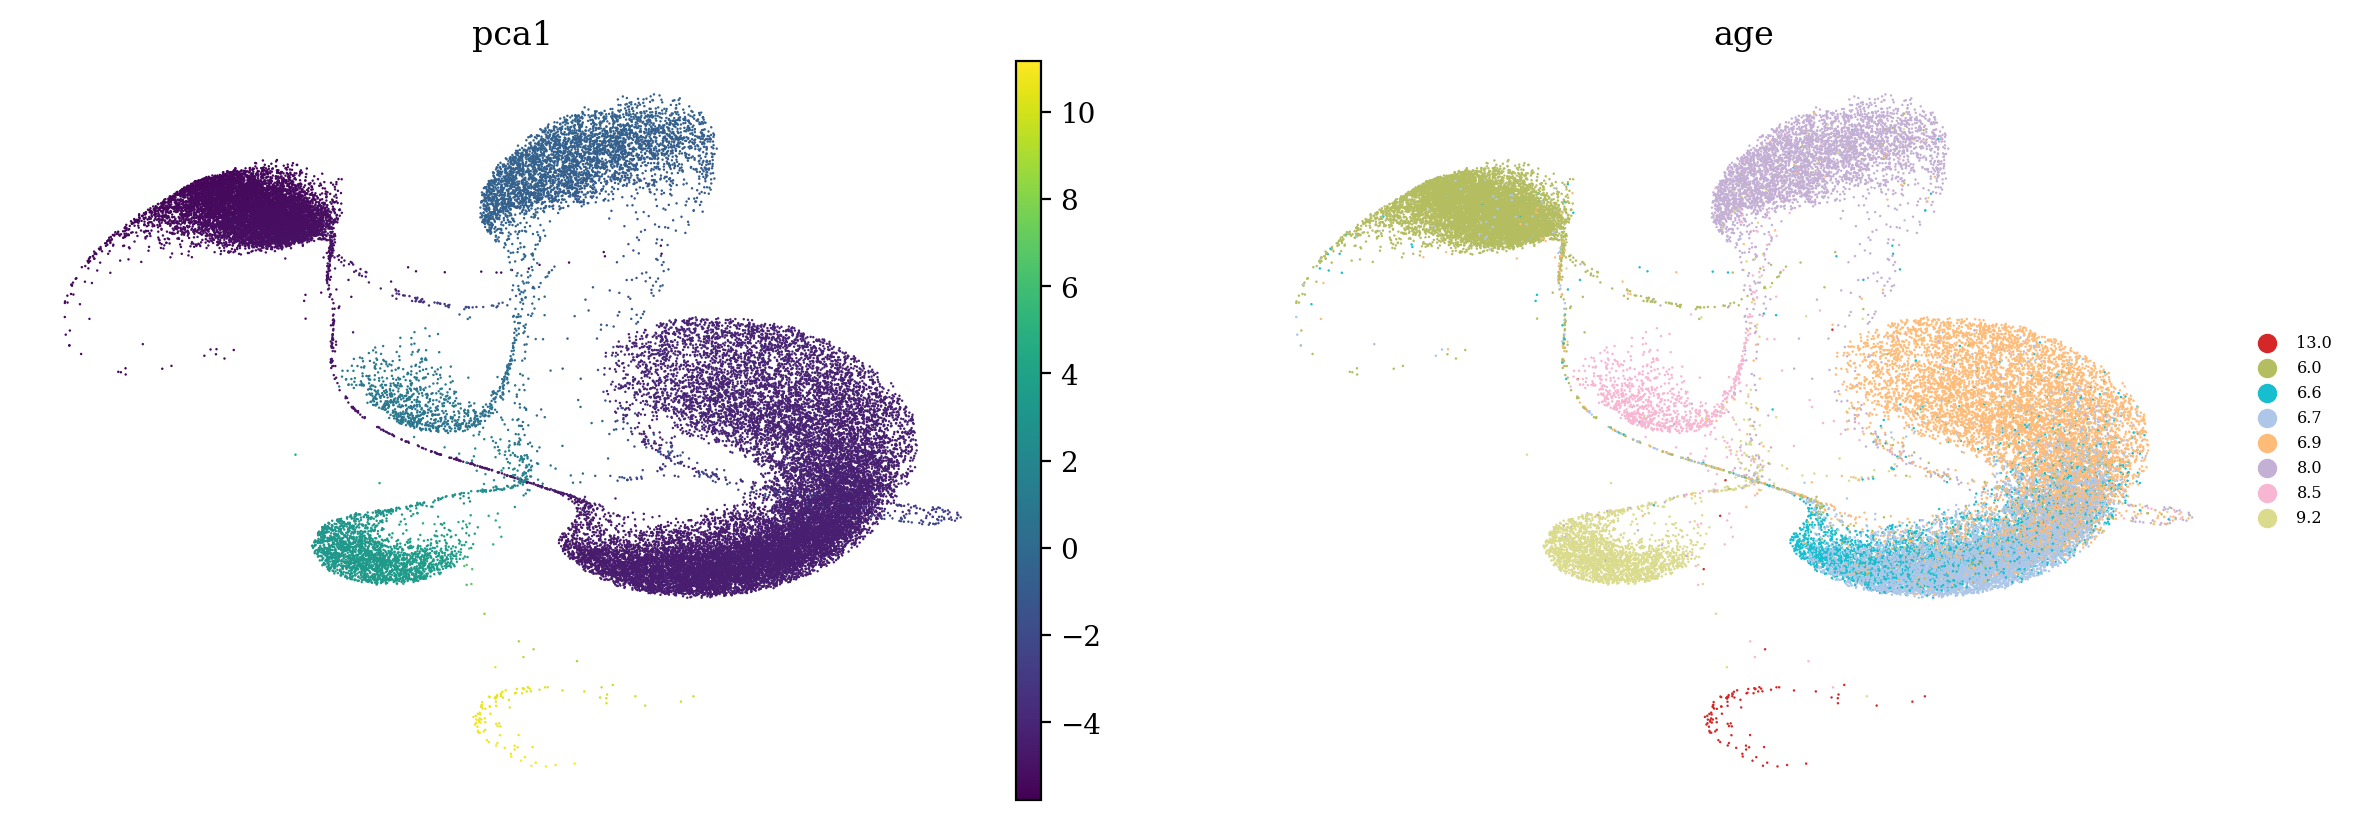

In [59]:
sc.pl.umap(
    _latent,
    color=["pca1", "age"],
    ncols=2,
    color_map="viridis",
    frameon=False,
    legend_fontsize="xx-small",
    show=False,
)
plt.show()

In [60]:
_adata = adata[_latent.obs.index].copy()
_adata.obs = _latent.obs.copy()
_adata.uns = _latent.uns.copy()
_adata.obsm = _latent.obsm.copy()
_adata.obsp = _latent.obsp.copy()

_adata = _adata[_adata.obs["pca1"].sort_values().index,:]
arr = _adata.X

GAL
PAX2
HOXA3
HOXA5
HOXA6
HOXB8
HOXB3
HOXA7
DBH
PAX8
LAMP5
HOXD3
CALY
LBX1
NXPH2
CRH
FEV
CALHM4
PHOX2A
SLC6A5
PNOC
PYDC1
HOXB2
SLC17A8
LRRC26
KRTDAP
HOXA4
HOXC4
HSPD1P8
LINC00331
FOXD3-AS1
ENSG00000231754.4
HOXB-AS3
HOTAIRM1
C5ORF58
LINC00682
PHOX2B-AS1
LINC02381
HOXB7
LINC00581


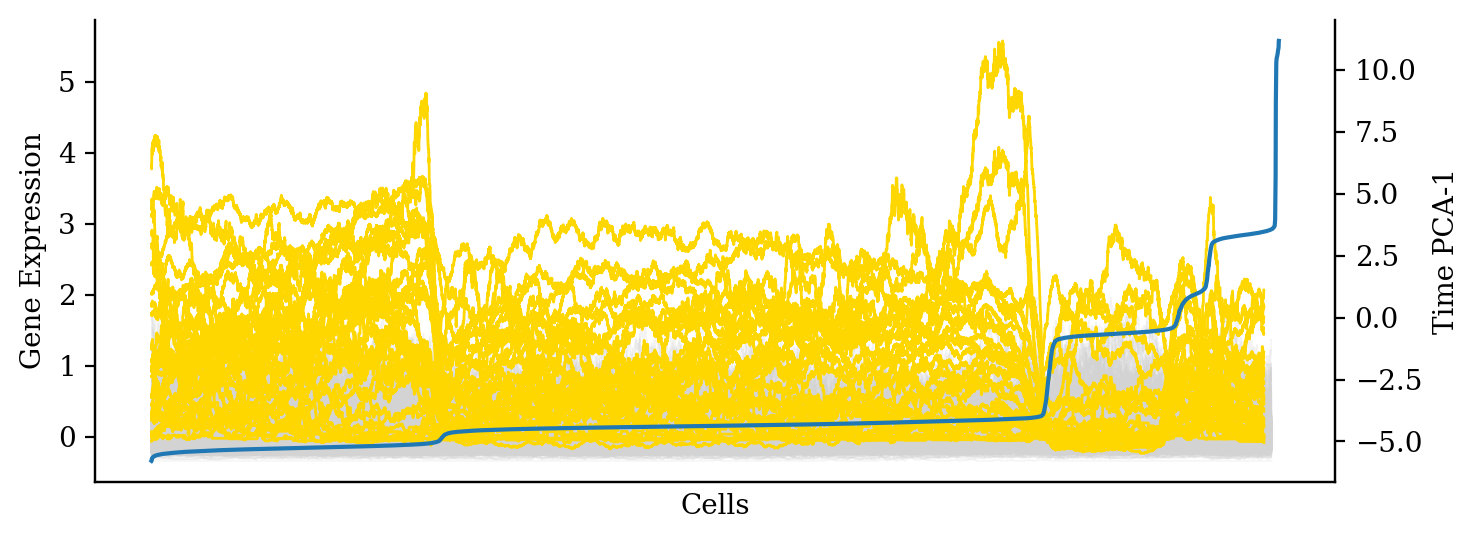

In [62]:
thr = 2
gene = 8192
mac = 2**8

from scanpy._utils import moving_average
zzarr = arr
plt.figure(figsize=(8, 3))
for i in range(gene):
    ma = moving_average(zzarr[:, i], mac)
    sign = np.all((thr > ma) & (-thr < ma))
    if sign:
        plt.plot(ma, linewidth=0.5, color="lightgray", alpha=0.25)
for i in range(gene):
    ma = moving_average(zzarr[:, i], 2**9)
    sign = np.all((thr > ma) & (-thr < ma))
    if not sign:
        plt.plot(ma, linewidth=1, color="gold", alpha=1)
        print(_adata.var["hgnc"][i])
plt.ylabel("Gene Expression")
plt.xlabel("Cells")
plt.xticks([])

# Creating a secondary y-axis
ax2 = plt.gca().twinx()
ax2.plot(range(len(_adata.obs["pca1"])), _adata.obs["pca1"])
ax2.set_ylabel("Time PCA-1")
sns.despine(right=False)
plt.show()

In [137]:
ma.shape

(48700,)

In [164]:
_adata.obs

sample_ID  organ   age  \
Braun_10X198_4:TGTAGACCACATCATG   BRC2191  Brain   6.9   
Braun_10X198_3:TCACGCTGTTGTGCCG   BRC2191  Brain   6.9   
Braun_10X198_4:GTTACCCCACCAGGTC   BRC2191  Brain   6.9   
Braun_10X198_3:CCTGCATTCACTGCTC   BRC2191  Brain   6.9   
Braun_10X198_3:AAACGAAAGCCACTCG   BRC2191  Brain   6.9   
...                                   ...    ...   ...   
Braun_10X255_6:GTGGAAGGTATGAGCG   XDD:385  Brain  14.0   
Braun_10X254_6:TGATGGTAGAATCGAT   XDD:385  Brain  14.0   
Braun_10X254_6:TGTTGAGAGTCATGCT   XDD:385  Brain  14.0   
Braun_10X254_5:CGGAATTCAGTAGTGG   XDD:385  Brain  14.0   
Braun_10X254_5:CCCTTAGTCACATCAG   XDD:385  Brain  14.0   

                                                cell_type sex sex_inferred  \
Braun_10X198_4:TGTAGACCACATCATG  Hypothalamus radial glia   M            M   
Braun_10X198_3:TCACGCTGTTGTGCCG  Hypothalamus radial glia   M            M   
Braun_10X198_4:GTTACCCCACCAGGTC  Hypothalamus radial glia   M            M   
Braun_10X198_3:CCTGCATTCACTGCTC  Hypothalamus radial glia   M            M   
Braun_10X198_3:AAACGAAAGCCACTCG  Hypothalamus radial glia   M            M   
...                                                   ...  ..          ...   
Braun_10X255_6:GTGGAAGGTATGAGCG  Hypothalamus radial glia   M            M   
Braun_10X254_6:TGATGGTAGAATCGAT  Hypothalamus radial glia   M            M   
Braun_10X254_6:TGTTGAGAGTCATGCT  Hypothalamus radial glia   M            M   
Braun_10X254_5:CGGAATTCAGTAGTGG  Hypothalamus radial glia   M            M   
Braun_10X254_5:CCCTTAGTCACATCAG  Hypothalamus radial glia   M            M   

                                 concatenated_integration_covariates  \
Braun_10X198_4:TGTAGACCACATCATG  BRC2191_Braun_et_al_Cell_Fresh_3GEX   
Braun_10X198_3:TCACGCTGTTGTGCCG  BRC2191_Braun_et_al_Cell_Fresh_3GEX   
Braun_10X198_4:GTTACCCCACCAGGTC  BRC2191_Braun_et_al_Cell_Fresh_3GEX   
Braun_10X198_3:CCTGCATTCACTGCTC  BRC2191_Braun_et_al_Cell_Fresh_3GEX   
Braun_10X198_3:AAACGAAAGCCACTCG  BRC2191_Braun_et_al_Cell_Fresh_3GEX   
...                                                              ...   
Braun_10X255_6:GTGGAAGGTATGAGCG  XDD:385_Braun_et_al_Cell_Fresh_3GEX   
Braun_10X254_6:TGATGGTAGAATCGAT  XDD:385_Braun_et_al_Cell_Fresh_3GEX   
Braun_10X254_6:TGTTGAGAGTCATGCT  XDD:385_Braun_et_al_Cell_Fresh_3GEX   
Braun_10X254_5:CGGAATTCAGTAGTGG  XDD:385_Braun_et_al_Cell_Fresh_3GEX   
Braun_10X254_5:CCCTTAGTCACATCAG  XDD:385_Braun_et_al_Cell_Fresh_3GEX   

                                   integration_donor  \
Braun_10X198_4:TGTAGACCACATCATG  BRC2191_Braun_et_al   
Braun_10X198_3:TCACGCTGTTGTGCCG  BRC2191_Braun_et_al   
Braun_10X198_4:GTTACCCCACCAGGTC  BRC2191_Braun_et_al   
Braun_10X198_3:CCTGCATTCACTGCTC  BRC2191_Braun_et_al   
Braun_10X198_3:AAACGAAAGCCACTCG  BRC2191_Braun_et_al   
...                                              ...   
Braun_10X255_6:GTGGAAGGTATGAGCG  XDD:385_Braun_et_al   
Braun_10X254_6:TGATGGTAGAATCGAT  XDD:385_Braun_et_al   
Braun_10X254_6:TGTTGAGAGTCATGCT  XDD:385_Braun_et_al   
Braun_10X254_5:CGGAATTCAGTAGTGG  XDD:385_Braun_et_al   
Braun_10X254_5:CCCTTAGTCACATCAG  XDD:385_Braun_et_al   

                                integration_biological_unit  \
Braun_10X198_4:TGTAGACCACATCATG                        Cell   
Braun_10X198_3:TCACGCTGTTGTGCCG                        Cell   
Braun_10X198_4:GTTACCCCACCAGGTC                        Cell   
Braun_10X198_3:CCTGCATTCACTGCTC                        Cell   
Braun_10X198_3:AAACGAAAGCCACTCG                        Cell   
...                                                     ...   
Braun_10X255_6:GTGGAAGGTATGAGCG                        Cell   
Braun_10X254_6:TGATGGTAGAATCGAT                        Cell   
Braun_10X254_6:TGTTGAGAGTCATGCT                        Cell   
Braun_10X254_5:CGGAATTCAGTAGTGG                        Cell   
Braun_10X254_5:CCCTTAGTCACATCAG                        Cell   

                                integration_sample_status  \
Braun_10X198_4:TGTAGACCACATCATG           

In [ ]:
import palantir

In [ ]:
latent = ad.AnnData(X=vae.get_latent_representation()[:, DisentanglementManager.configurations.get_by_obs_key("age").reserved_latent_indices], obs=adata.obs.copy())
sc.tl.pca(latent, n_comps=7)

In [ ]:
dm_res = palantir.utils.run_diffusion_maps(latent, n_components=4)
ms_data = palantir.utils.determine_multiscale_space(latent)

In [ ]:
rsc.utils.anndata_to_GPU(latent)
rsc.pp.neighbors(adata=latent)
rsc.tl.umap(adata=latent)

In [ ]:
start_cell = latent.obs.index[np.where([latent.obs["age_continuous"] == latent.obs["age_continuous"].min()])[1]][20]
end_cell = latent.obs.index[np.where([latent.obs["age_continuous"] == latent.obs["age_continuous"].max()])[1]][0]

In [ ]:
terminal_states = pd.Series(
    ["time0", "time100"],
    index=[start_cell, end_cell],
)

palantir.plot.highlight_cells_on_umap(latent, terminal_states)
plt.show()

In [ ]:
palantir.plot.plot_diffusion_components(latent)

In [ ]:
pr_res = palantir.core.run_palantir(
    latent, start_cell, terminal_states=terminal_states
)

In [ ]:
sc.pl.umap(
    latent,
    color=["palantir_pseudotime", "age_continuous", "age", "palantir_entropy"],
    ncols=2,
    color_map="inferno",
    frameon=False,
    legend_fontsize="xx-small",
    show=False,
)
plt.show()

In [ ]:
sns.violinplot(data=latent.obs, x="age_continuous", y="palantir_pseudotime", linewidth=1, color="gray")

In [ ]:
latent.obs["pca1"] = latent.obsm["X_pca"][:, 0].copy()
sns.scatterplot(latent.obs, x="pca1", y="palantir_pseudotime", s=1)

In [ ]:
sns.violinplot(data=latent.obs, x="age_continuous", y="pca1", linewidth=1, color="gray")

In [ ]:
sns.histplot(latent.obsm["X_pca"][:, 0], bins=256, stat="density")